# MGAB-V3395: Orbital Exploration
In this notebook we will look at the MGAB-V3395 data and attempt to determine whether or not it is possible that the eclipses are explained by a binary star system where one of the components has a circumstellar disk at some inclination / tilt... etc. Our main goal is to determine whether or not the secondary star can have a stable circumstellar disk based on the orbital parameters we currently know (i.e. is $R_\mathrm{disk} < 0.3 R_\mathrm{Hill}$).

![](light_curve_phased.png)

## Importing Modules
We import all the necessary modules for the succeeding analysis.

In [1]:
import numpy as np
from kepler3 import *
from tqdm import tqdm
from astropy import units as u
import matplotlib.pyplot as plt
from astropy import constants as c

%matplotlib inline

## Testing Circular Orbit
We first attempt to see if a circular orbit can fulfill the Hill radius stability criterion. We will test a random (but "realistic" situation)

In [2]:
# Known Parameters
P = 227. * u.d

# Measured Parameters
tpri = (58292. - 58247) * u.day
tsec = 2./3. * tpri

# Assumed Parameters
ma = 1.0 * u.M_sun
mb = 0.8 * u.M_sun

# Print Statements
print('Period is {}'.format(P))
print('')
print('Primary Eclipse Duration is {}'.format(tpri))
print('Secondary Eclipse Duration is {}'.format(tsec))
print('')
print('Proposed Primary Mass is {}'.format(ma))
print('Proposed Secondary Mass is {}'.format(mb))

Period is 227.0 d

Primary Eclipse Duration is 45.0 d
Secondary Eclipse Duration is 30.0 d

Proposed Primary Mass is 1.0 solMass
Proposed Secondary Mass is 0.8 solMass


We then derive some of the orbital parameters to determine the disk and Hill radius

In [4]:
# Derive Orbital Parameters
a = Ptoa(P, ma, mb)
vc = vcirc(ma,mb, a)

# Determine Disk and Hill radii
Rdpri = 0.5 * (tpri * vc).to(u.au)
Rhill = rhill(ma, mb, a)


# Print Parameters
print('Semi-major Axis is {:.2f}'.format(a))
print('Circular Velocity is {:.2f}'.format(vc))
print('')
print('Disk Radius (Primary Eclipse) is {:.2f}'.format(Rdpri))
print('Hill Radius is {:.2f}'.format(Rhill))

Semi-major Axis is 0.89 AU
Circular Velocity is 42.46 km / s

Disk Radius (Primary Eclipse) is 0.55 AU
Hill Radius is 0.47 AU


$R_\mathrm{disk}$ is larger than $R_\mathrm{Hill}$, which tells us that the secondary must be on an eccentric orbit, so we will attempt that next.

## Testing Eccentric Orbits
We determined in the previous section that a circular orbit is not possible. We therefore take a close look at possible eccentric orbits and the orbital parameters of MGAB-V3395. For this we look closely at a phase-folded light curve.

![](light_curve_phased.png)

We note that the phase offset $\left(\frac{t}{P}\right)$ between the primary and the secondary eclipse is <strong>not</strong> 0.5 as one would normally expect. This is most likely caused by an eccentric orbit that is not viewed along the orbit (i.e. the transit of occulter is not at peri- or apastron. We know that the time of the secondary eclipse is as follows:

$ t = \frac{P}{2}\left [ 1+4e\cos (\omega)\right ] \rightarrow \frac{2t}{P} = \left[ 1+4e\cos (\omega) \right] \rightarrow \frac{1}{4}\left(\frac{2t}{P} - 1\right) = \left[ e\cos (\omega) \right] $

In [5]:
# we measure the phase shift to be ~ tP
tP = 0.62

# determine the value of e cos(w)
ecosomega = 0.25 * (2 * tP - 1)

print('for a t/P of {} --> e cos(\u03C9) is {}'.format(tP, ecosomega))

for a t/P of 0.62 --> e cos(ω) is 0.06


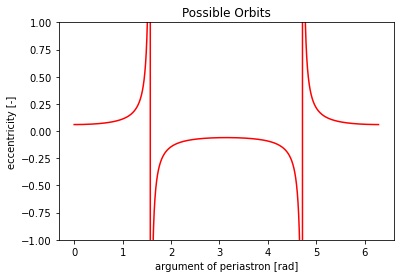

In [6]:
# cos omega must be within +-1 thus smallest e is when cos omega is 1
omega = np.linspace(0, 2*np.pi, 10001)
e = ecosomega / np.cos(omega)

# plot it
plt.figure()
plt.plot(omega, e, 'r-')
plt.xlabel('argument of periastron [rad]')
plt.ylabel('eccentricity [-]')
plt.title('Possible Orbits')
plt.ylim(-1, 1)
plt.show()

based on the above plot we see reflection symmetry about $\pi$, which makes sense when thinking of orbits. Using this we can determine what the transit velocity is and thus the size of the disk, which allows us to test it's stability.

## Parameter Maps
We will investigate if we can find an orbit that produces a stable disk that could provide the eclipse as measured. This is based on the assumption that the disk is transiting close to periastron (more likely in terms of geometry and thus likelihood of a transit) or apastron (less likely in terms of geometry and thus likelihood of a transit).

In [7]:
# determine grid parameters
q = np.linspace(0,2,2001) # mass ratio
e = np.linspace(0,1,1001) # eccentricties to test

# determine mass parameters
M1 = 1*u.Msun
M2 = q * M1

# determine period
P = 227*u.day

# calculate the semi-major axis, peri- and apastron distance
# Hill radius and periastron velocity
a   = Ptoa(P, M1, M2)
rp  = (1-e[:,None]) * a
rap = (1+e[:,None]) * a
rh  = rhill(M1, M2, rp)
vp  = visviva(a[None, :], rp, M1, M2[None, :])

/Users/dmvandam/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


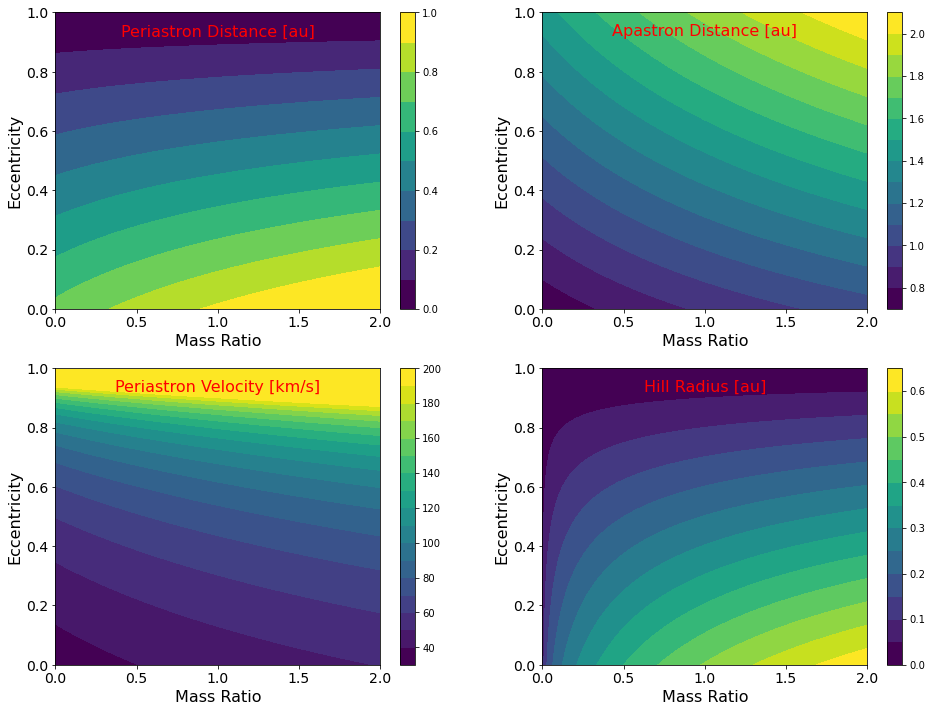

In [8]:
# plot the parameters above
params = [[rp, rap], [vp, rh]]
titles = [['Periastron Distance [au]', 'Apastron Distance [au]'], ['Periastron Velocity [km/s]', 'Hill Radius [au]']]
vmins  = [[0, 0.7], [30, 0]]
vmaxs  = [[1, 2.1], [200, 0.65]]
nums   = [[10, 14], [17, 13]]

fig, axes = plt.subplots(2, 2, figsize=(16,12))
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        title = titles[i][j]
        param = params[i][j]
        num   = nums[i][j]
        vmin  = vmins[i][j]
        vmax  = vmaxs[i][j]
        ax.tick_params(labelsize=14)
        ax.set_title(title, fontsize=16, y=0.9, color='r')
        ax.set_xlabel('Mass Ratio', fontsize=16)
        ax.set_ylabel('Eccentricity', fontsize=16)
        im = ax.imshow(param, extent=(0, 2, 0, 1), aspect='auto', cmap=plt.cm.get_cmap('viridis', num), 
                vmin=vmin, vmax=vmax, origin='lower left')
        plt.colorbar(im, ax=ax)
plt.show()

Now we need to incorporate the phase shift between the primary and secondary eclipse (i.e. 0.62 instead of the "normal" 0.5), this poses a requirement on the argument of periastron. This requirement gives us a transit velocity of the disk, with the transit velocity we can determine the size of the disk, and whether or not it can survive the periastron passage.

In [9]:
def get_velocity_at_LOS(P, a, e, omega, plot=False):
    '''
    This function is used to determine the velocity of the orbiting
    object across the line of sight using kep3d from kepler3
    
    Parameters
    ----------
    P : astropy.Quantity
        period [days]
    a : astropy.Quantity
        semi-major axis [au]
    e : float
        eccentricity
    omega : astropy.Quantity
        longitude of periastron [rad]
    plot : bool
        if true, plot a diagnostic [default=False]
    
    Returns
    -------
    vel : astropy.Quantity
        velocity of orbiting body [km/s]
    '''
    # determine orbital parameters
    epoch = np.linspace(0, P.value, 10001) * P.unit
    tperi = 0 * u.day
    inc   = 0 * u.deg
    anode = 0 * u.deg
    # calculating orbit
    _, _, X, Y, _, Vx, Vy, _ = kep3d(epoch, P, tperi, a, e, inc, 
                                     omega, anode)
    # determine mask (peri- or apastron)
    masks = [[Y > 0], [Y < 0]]
    pis   = [0, 5000]
    lbls  = ['periastron', 'apastron']
    mrks  = ['o', 'x']
    mrks2 = ['^', 'v']
    inds  = []
    vels  = []
    # determine the transit velocities along periastron and apastron LOS
    for mask in masks:
        ind = np.argmin(np.abs(X[mask]))
        Vlx = Vx[mask][ind]
        Vly = Vy[mask][ind]
        vel = np.hypot(Vlx, Vly).to(u.km/u.s)
        inds.append(ind)
        vels.append(vel)
    # periastron and apastron velocities
    vp, va = vels
    if plot == True:
        # reference
        _, _, x, y, _, _, _, _ = kep3d(epoch, P, tperi, a, e, inc, 
                                       0*u.rad, anode)
        plt.figure(figsize=(8, 8))
        plt.gca().set_aspect('equal')
        # plot un-rotated reference orbit
        plt.plot(x, y, 'r-', alpha=0.2,
                 label='reference ($\omega$ = {:.2f})'.format(0*u.deg))
        # plot reference peri and apastron distances
        for pi, lbl, mrk in zip(pis, lbls, mrks):
            plt.plot(x[pi], y[pi], color='k', marker=mrk, alpha=0.2,
                     label='reference %s' % lbl)
        # plot actual orbit
        plt.plot(X, Y, 'r-', 
                 label='$\omega$ = {:.2f}'.format(omega.to(u.deg)))
        # plot actual peri and apastron distances
        for pi, lbl, mrk in zip(pis, lbls, mrks):
            plt.plot(X[pi], Y[pi], 'k%s' % mrk, label=lbl)
        # plot LOS locations
        for mask, ind, lbl, mrk2 in zip(masks, inds, lbls, mrks2):
            plt.scatter(X[mask][ind], Y[mask][ind], marker=mrk2, 
                        color='g', s=100, label='LOS - %s' % lbl)
        # plot primary location
        plt.scatter(0*u.au, 0*u.au, marker='o', color='b', 
                    label='primary')
        # figure parameters
        plt.xlabel('X [au]')
        plt.ylabel('Y [au]')
        plt.title('2D orbit')
        plt.grid()
        plt.legend(bbox_to_anchor=[1.0, 0.5], loc='center left')
        plt.show()
    return vp, va


We test the above function for a random orbit, here we select $\mathrm{ind}_q = 100, \mathrm{ind}_e = 500$.

/Users/dmvandam/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:1032: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


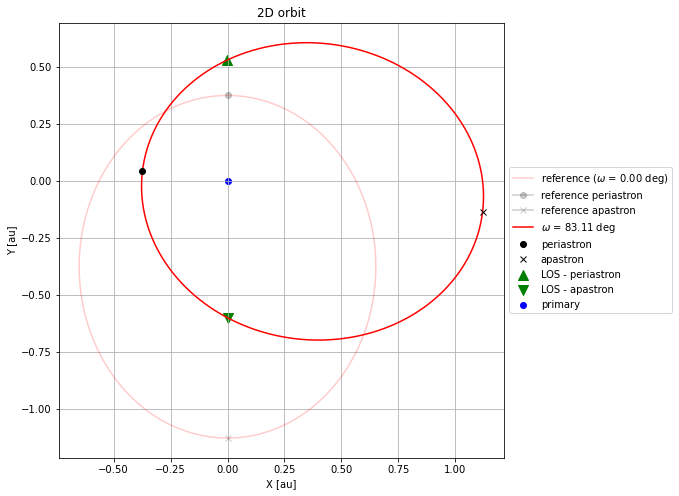

transit (periastron) velocity 48.70 km / s
transit (apastron) velocity 44.22 km / s
periastron velocity 62.40 km / s
ratio (tp/p) 0.78 and ratio (ta/p) 0.71


In [14]:
# determine the transit velocity
A = a[100]
E = e[500]
O = np.arccos(ecosomega / E) * u.rad
vel_tp, vel_ta = get_velocity_at_LOS(P, A, E, O, plot=True)

# determine periastron velocity (for printing)
vel_p, vel_a = get_velocity_at_LOS(P, A, E, 0*O, plot=False)


# print findings
print('transit (periastron) velocity {:.2f}'.format(vel_tp))
print('transit (apastron) velocity {:.2f}'.format(vel_ta))
print('periastron velocity {:.2f}'.format(vel_p))
print('ratio (tp/p) {:.2f} and ratio (ta/p) {:.2f}'.format(vel_tp/vel_p, vel_ta/vel_p))

Note that this velocity is at the mid-point of the primary eclipse (this is based on the fact that the $\left(\frac{t}{P}\right) = 0.62$ is measured from the eclipse midpoints). We believe this method and now calculate the disk radii for each point (this is cumbersome). For (1001, 2001) this takes ~ 7 hours.

In [15]:
# calculate transit (periastron) velocities
try:
    # attempt to load velocities
    vtp = np.load('vtp.npy') * u.km/u.s
    vta = np.load('vta.npy') * u.km/u.s
except:
    # calculate velocities
    vtp = np.zeros(rh.shape)
    vta = np.zeros(rh.shape)
    ne, nq = vtp.shape
    for i in tqdm(range(ne)):
        for j in range(nq):
            arg = ecosomega / e[i]
            if np.abs(arg) > 1:
                vtp[i, j] = np.nan
                vta[i, j] = np.nan
            else:
                omega = np.arccos(arg) * u.rad
                try:
                    vt = get_velocity_at_LOS(P, a[j], e[i], omega)
                    vtp[i, j] = vt[0].value
                    vta[i, j] = vt[1].value
                except:
                    vtp[i, j] = np.nan
                    vta[i, j] = np.nan
    vtp *= u.km/u.s
    vta *= u.km/u.s

# save velocities to prevent later issues
np.save('vtp.npy', vtp.value)
np.save('vta.npy', vta.value)

With the velocities we can determine disk radii (periastron) and check to see if there are any stable disks.

### Testing Transit (Periastron) Velocities
Here we look at the disk sizes based on periastron transit velocities.

In [16]:
rdp = (vtp*tpri/2.).to(u.au)

Periastron Velocity [km/s] = 34.90 km / s to inf km / s
Transit (Periastron) Velocity [km/s] = 37.06 km / s to 2250.60 km / s
Hill Radius [au] = 0.00 AU to 0.64 AU
Disk (Periastron) Radius  [au] = 0.48 AU to 29.25 AU


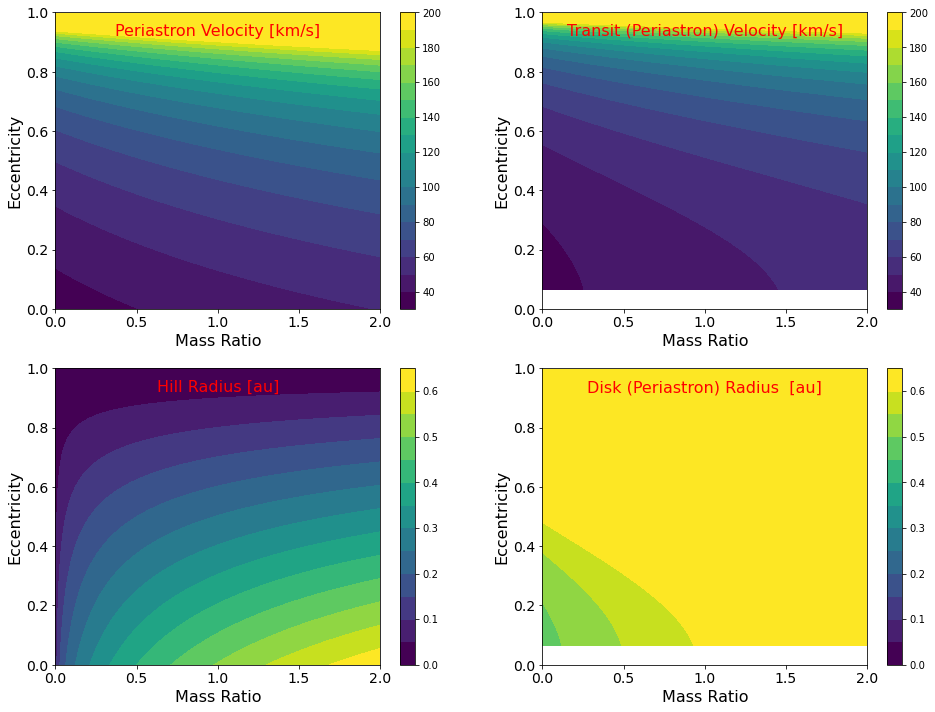

In [17]:
# plot parameters
params2 = [[vp, vtp], [rh, rdp]]
titles2 = [['Periastron Velocity [km/s]', 'Transit (Periastron) Velocity [km/s]'], 
           ['Hill Radius [au]', 'Disk (Periastron) Radius  [au]']]
vmins2  = [[30, 30], [0, 0]]
vmaxs2  = [[200, 200], [0.65, 0.65]]
nums2   = [[17, 17], [13, 13]]

fig, axes = plt.subplots(2, 2, figsize=(16,12))
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        title = titles2[i][j]
        param = params2[i][j]
        num   = nums2[i][j]
        vmin  = vmins2[i][j]
        vmax  = vmaxs2[i][j]
        ax.tick_params(labelsize=14)
        ax.set_title(title, fontsize=16, y=0.9, color='r')
        ax.set_xlabel('Mass Ratio', fontsize=16)
        ax.set_ylabel('Eccentricity', fontsize=16)
        im = ax.imshow(param, extent=(0, 2, 0, 1), aspect='auto', cmap=plt.cm.get_cmap('viridis', num), 
                vmin=vmin, vmax=vmax, origin='lower left')
        plt.colorbar(im, ax=ax)
        print('{} = {:.2f} to {:.2f}'.format(title, np.nanmin(param), np.nanmax(param)))
plt.show()




We now check if any of disks are stable.

/Users/dmvandam/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


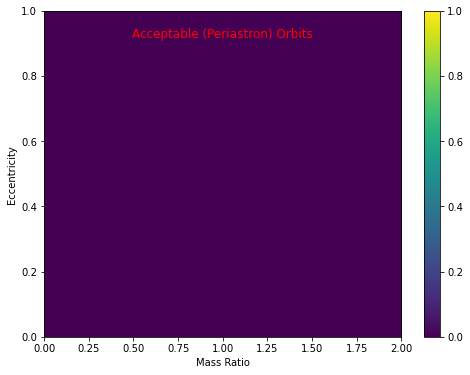

number of stable orbits 0
percentage of stable orbits 0.00%


In [18]:
maskp = rdp < 0.3 * rh

plt.figure(figsize=(8, 6))
plt.imshow(maskp, extent=(0, 2, 0, 1), origin='lower left', 
           aspect='auto', vmin=0, vmax=1)
plt.xlabel('Mass Ratio')
plt.ylabel('Eccentricity')
plt.title('Acceptable (Periastron) Orbits', y=0.9, color='r')
plt.colorbar()
plt.show()

num_tp = np.sum(maskp)
totalp = np.prod(maskp.shape)
print('number of stable orbits {}'.format(num_tp))
print('percentage of stable orbits {:.2f}%'.format(num_tp/totalp))

### Testing Transit (Apastron) Velocities
Here we look at the disk sizes based on apastron transit velocities.

In [19]:
rda = (vta*tpri/2.).to(u.au)

Periastron Velocity [km/s] = 34.90 km / s to inf km / s
Transit (Apastron) Velocity [km/s] = 32.87 km / s to 537345619.08 km / s
Hill Radius [au] = 0.00 AU to 0.64 AU
Disk (Apastron) Radius  [au] = 0.43 AU to 6982718.93 AU


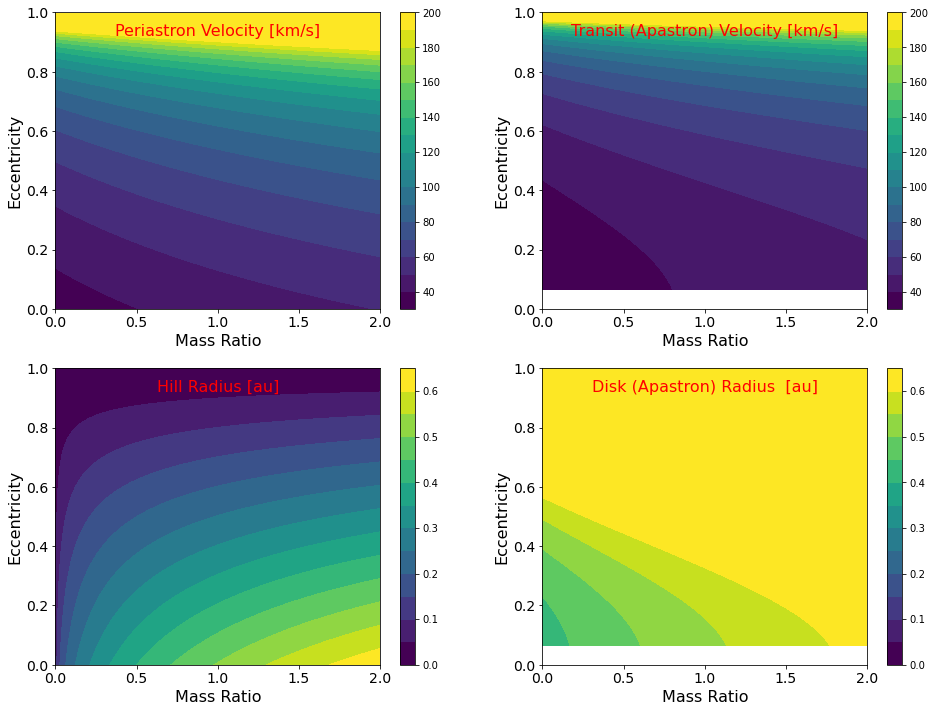

In [20]:
# plot parameters
params3 = [[vp, vta], [rh, rda]]
titles3 = [['Periastron Velocity [km/s]', 'Transit (Apastron) Velocity [km/s]'], 
           ['Hill Radius [au]', 'Disk (Apastron) Radius  [au]']]
vmins3  = [[30, 30], [0, 0]]
vmaxs3  = [[200, 200], [0.65, 0.65]]
nums3   = [[17, 17], [13, 13]]

fig, axes = plt.subplots(2, 2, figsize=(16,12))
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        title = titles3[i][j]
        param = params3[i][j]
        num   = nums3[i][j]
        vmin  = vmins3[i][j]
        vmax  = vmaxs3[i][j]
        ax.tick_params(labelsize=14)
        ax.set_title(title, fontsize=16, y=0.9, color='r')
        ax.set_xlabel('Mass Ratio', fontsize=16)
        ax.set_ylabel('Eccentricity', fontsize=16)
        im = ax.imshow(param, extent=(0, 2, 0, 1), aspect='auto', 
                       cmap=plt.cm.get_cmap('viridis', num), 
                       vmin=vmin, vmax=vmax, origin='lower left')
        plt.colorbar(im, ax=ax)
        print('{} = {:.2f} to {:.2f}'.format(title, np.nanmin(param), np.nanmax(param)))
plt.show()



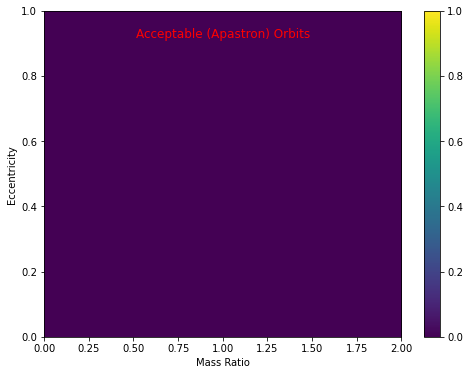

number of stable orbits 0
percentage of stable orbits 0.00%


In [21]:
maska = rda < 0.3 * rh

plt.figure(figsize=(8, 6))
plt.imshow(maska, extent=(0, 2, 0, 1), origin='lower left', 
           aspect='auto', vmin=0, vmax=1)
plt.xlabel('Mass Ratio')
plt.ylabel('Eccentricity')
plt.title('Acceptable (Apastron) Orbits', y=0.9, color='r')
plt.colorbar()
plt.show()

num_ta = np.sum(maska)
totala = np.prod(maska.shape)
print('number of stable orbits {}'.format(num_ta))
print('percentage of stable orbits {:.2f}%'.format(num_ta/totala))

## Secondary Eclipse
In the previous sections we attempted to model the primary eclipse as a circumstellar disk crossing the star. This turned out to leave us with no acceptable orbit. We can see if the secondary eclipse would work.

### Testing Transit (Periastron) Velocities
Here we look at the disk sizes based on periastron transit velocities.

In [22]:
rdp2 = (vtp*tsec/2.).to(u.au)

Periastron Velocity [km/s] = 34.90 km / s to inf km / s
Transit (Periastron) Velocity [km/s] = 37.06 km / s to 2250.60 km / s
Hill Radius [au] = 0.00 AU to 0.64 AU
Disk (Periastron) Radius  [au] = 0.32 AU to 19.50 AU


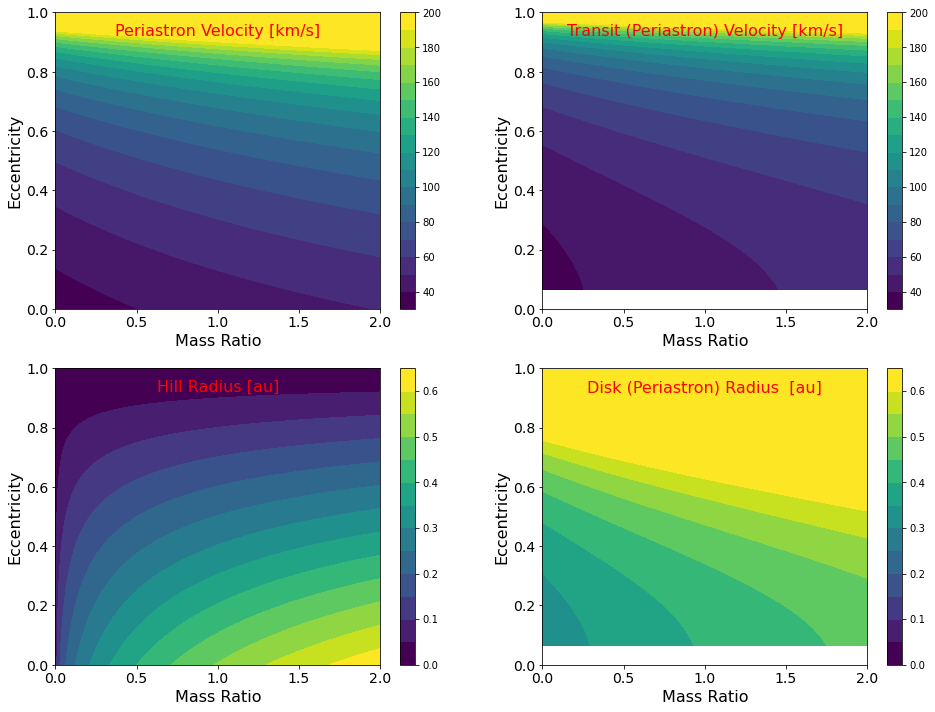

In [23]:
# plot parameters
params4 = [[vp, vtp], [rh, rdp2]]
titles4 = [['Periastron Velocity [km/s]', 'Transit (Periastron) Velocity [km/s]'], 
           ['Hill Radius [au]', 'Disk (Periastron) Radius  [au]']]
vmins4  = [[30, 30], [0, 0]]
vmaxs4  = [[200, 200], [0.65, 0.65]]
nums4   = [[17, 17], [13, 13]]

fig, axes = plt.subplots(2, 2, figsize=(16,12))
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        title = titles4[i][j]
        param = params4[i][j]
        num   = nums4[i][j]
        vmin  = vmins4[i][j]
        vmax  = vmaxs4[i][j]
        ax.tick_params(labelsize=14)
        ax.set_title(title, fontsize=16, y=0.9, color='r')
        ax.set_xlabel('Mass Ratio', fontsize=16)
        ax.set_ylabel('Eccentricity', fontsize=16)
        im = ax.imshow(param, extent=(0, 2, 0, 1), aspect='auto', cmap=plt.cm.get_cmap('viridis', num), 
                vmin=vmin, vmax=vmax, origin='lower left')
        plt.colorbar(im, ax=ax)
        print('{} = {:.2f} to {:.2f}'.format(title, np.nanmin(param), np.nanmax(param)))
plt.show()




We now check if any of disks are stable.

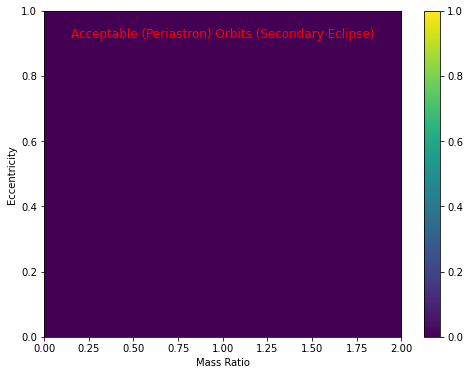

number of stable orbits 0
percentage of stable orbits 0.00%


In [24]:
maskp2 = rdp2 < 0.3 * rh

plt.figure(figsize=(8, 6))
plt.imshow(maskp2, extent=(0, 2, 0, 1), origin='lower left', 
           aspect='auto', vmin=0, vmax=1)
plt.xlabel('Mass Ratio')
plt.ylabel('Eccentricity')
plt.title('Acceptable (Periastron) Orbits (Secondary Eclipse)', y=0.9, color='r')
plt.colorbar()
plt.show()

num_tp2 = np.sum(maskp2)
totalp2 = np.prod(maskp2.shape)
print('number of stable orbits {}'.format(num_tp2))
print('percentage of stable orbits {:.2f}%'.format(num_tp2/totalp2))

### Testing Transit (Apastron) Velocities
Here we look at the disk sizes based on apastron transit velocities.

In [25]:
rda2 = (vta*tsec/2.).to(u.au)

Periastron Velocity [km/s] = 34.90 km / s to inf km / s
Transit (Apastron) Velocity [km/s] = 32.87 km / s to 537345619.08 km / s
Hill Radius [au] = 0.00 AU to 0.64 AU
Disk (Apastron) Radius  [au] = 0.28 AU to 4655145.95 AU


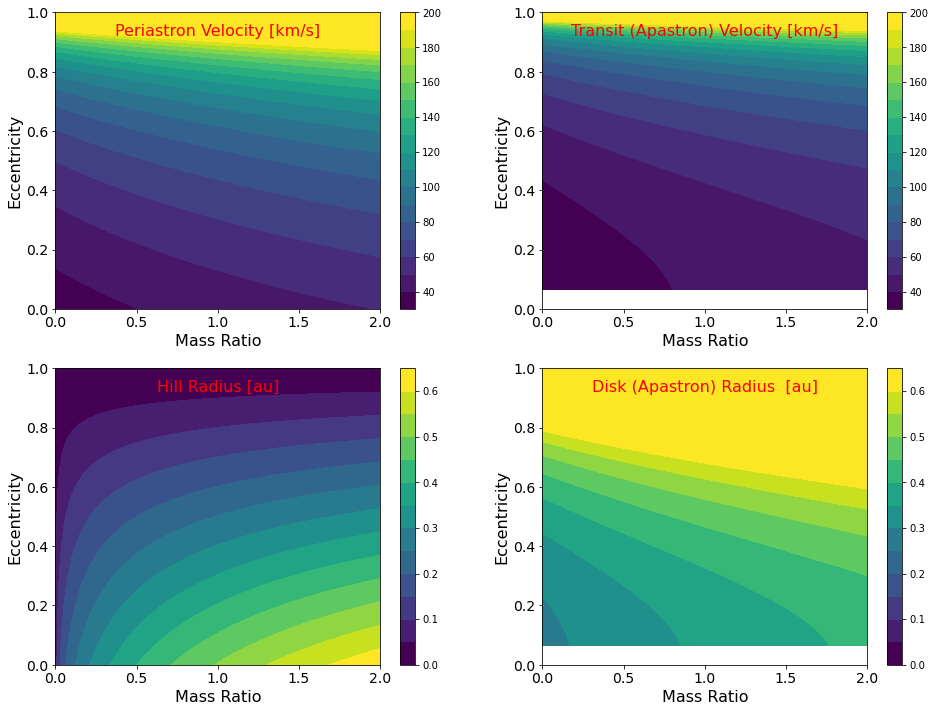

In [26]:
# plot parameters
params5 = [[vp, vta], [rh, rda2]]
titles5 = [['Periastron Velocity [km/s]', 'Transit (Apastron) Velocity [km/s]'], 
           ['Hill Radius [au]', 'Disk (Apastron) Radius  [au]']]
vmins5  = [[30, 30], [0, 0]]
vmaxs5  = [[200, 200], [0.65, 0.65]]
nums5   = [[17, 17], [13, 13]]

fig, axes = plt.subplots(2, 2, figsize=(16,12))
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        title = titles5[i][j]
        param = params5[i][j]
        num   = nums5[i][j]
        vmin  = vmins5[i][j]
        vmax  = vmaxs5[i][j]
        ax.tick_params(labelsize=14)
        ax.set_title(title, fontsize=16, y=0.9, color='r')
        ax.set_xlabel('Mass Ratio', fontsize=16)
        ax.set_ylabel('Eccentricity', fontsize=16)
        im = ax.imshow(param, extent=(0, 2, 0, 1), aspect='auto', 
                       cmap=plt.cm.get_cmap('viridis', num), 
                       vmin=vmin, vmax=vmax, origin='lower left')
        plt.colorbar(im, ax=ax)
        print('{} = {:.2f} to {:.2f}'.format(title, np.nanmin(param), np.nanmax(param)))
plt.show()



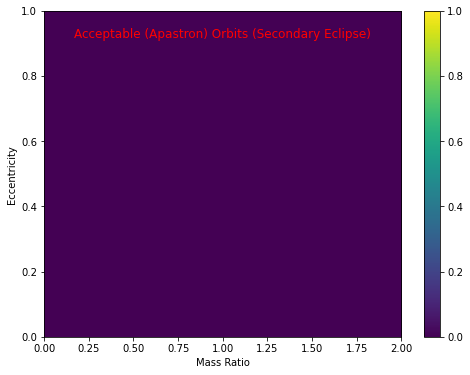

number of stable orbits 0
percentage of stable orbits 0.00%


In [27]:
maska2 = rda2 < 0.3 * rh

plt.figure(figsize=(8, 6))
plt.imshow(maska2, extent=(0, 2, 0, 1), origin='lower left', 
           aspect='auto', vmin=0, vmax=1)
plt.xlabel('Mass Ratio')
plt.ylabel('Eccentricity')
plt.title('Acceptable (Apastron) Orbits (Secondary Eclipse)', y=0.9, color='r')
plt.colorbar()
plt.show()

num_ta2 = np.sum(maska2)
totala2 = np.prod(maska2.shape)
print('number of stable orbits {}'.format(num_ta2))
print('percentage of stable orbits {:.2f}%'.format(num_ta2/totala2))

## Conclusion
Unfortunately we can't seem to find a stable orbit for MGAB - V3395.